# console : mlflow ui
# Accès console MLFlow : http://127.0.0.1:5000
# 1 - Chargement & configuration - 18 sec

In [1]:
import sys
import os
sys.path.append('../src')
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

from requirements import *
from src import data_preprocessing as dp
from src import model_training as mt
from src import evaluate as ev
from src import utils

import mlflow
mlflow.set_experiment("Sentiment Analysis Project")

c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P07\P7_sentiment_MLOps\env_p7_MLOps\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\motar\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!




✅ Toutes les librairies sont présentes et prêtes à être utilisées !



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\motar\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\motar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\motar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Traceback (most recent call last):
  File "c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P07\P7_sentiment_MLOps\env_p7_MLOps\lib\site-packages\mlflow\store\tracking\file_store.py", line 329, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P07\P7_sentiment_MLOps\env_p7_MLOps\lib\site-packages\mlflow\store\tracking\file_store.py", line 427, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir

<Experiment: artifact_location='file:///c:/Users/motar/Desktop/1-openclassrooms/AI_Engineer/1-projets/P07/P7_sentiment_MLOps/notebooks/mlruns/906586012259731436', creation_time=1742576058928, experiment_id='906586012259731436', last_update_time=1742576058928, lifecycle_stage='active', name='Sentiment Analysis Project', tags={}>

## 1.1 - Démarrage automatique du serveur MLflow (Backend SQLite + Artifact Store local)

In [2]:
utils.start_mlflow_server(port = 5000)
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("projet analyse sentiments")

🚀 Démarrage du serveur MLflow (SQLite backend)...
✅ MLflow UI disponible sur : http://127.0.0.1:5000


<Experiment: artifact_location='file:///c:/Users/motar/Desktop/1-openclassrooms/AI_Engineer/1-projets/P07/P7_sentiment_MLOps/notebooks/mlruns/3', creation_time=1742808098078, experiment_id='3', last_update_time=1742808098078, lifecycle_stage='active', name='projet analyse sentiments', tags={}>

## 1.2 - Affichage de la structure dossier

In [3]:
utils.afficher_structure_dossier("..", max_niveaux = 2)

├── .dockerignore
├── .git
├── ├── COMMIT_EDITMSG
├── ├── FETCH_HEAD
├── ├── HEAD
├── ├── config
├── ├── description
├── ├── hooks
│   ├── ├── applypatch-msg.sample
│   ├── ├── commit-msg.sample
│   ├── ├── fsmonitor-watchman.sample
│   ├── ├── post-update.sample
│   ├── ├── pre-applypatch.sample
│   ├── ├── pre-commit.sample
│   ├── ├── pre-merge-commit.sample
│   ├── ├── pre-push.sample
│   ├── ├── pre-rebase.sample
│   ├── ├── pre-receive.sample
│   ├── ├── prepare-commit-msg.sample
│   ├── ├── push-to-checkout.sample
│   ├── ├── sendemail-validate.sample
│   ├── └── update.sample
├── ├── index
├── ├── info
│   ├── └── exclude
├── ├── logs
│   ├── ├── HEAD
│   ├── └── refs
├── ├── objects
│   ├── ├── 00
│   ├── ├── 01
│   ├── ├── 02
│   ├── ├── 03
│   ├── ├── 04
│   ├── ├── 05
│   ├── ├── 06
│   ├── ├── 08
│   ├── ├── 09
│   ├── ├── 0b
│   ├── ├── 0d
│   ├── ├── 0e
│   ├── ├── 0f
│   ├── ├── 12
│   ├── ├── 13
│   ├── ├── 15
│   ├── ├── 18
│   ├── ├── 19
│   ├── ├── 1a
│   ├── ├── 1b

## 1.3 - Chargement des données

In [4]:
print(f"📂 Répertoire courant : {os.getcwd()}")

📂 Répertoire courant : c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P07\P7_sentiment_MLOps\notebooks


In [5]:
data_path = "../data/tweets.csv"
if os.path.exists(data_path):
    tweets = pd.read_csv(data_path, encoding = "ISO-8859-1")
    print("✅ Dataset chargé avec succès !")
else:
    print("❌ Le fichier tweets.csv est introuvable.")

✅ Dataset chargé avec succès !


# 2 - Exploration & nettoyage
## 2.1 - Nettoyage initial

In [6]:
print(tweets.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column                                                                                                               Non-Null Count    Dtype 
---  ------                                                                                                               --------------    ----- 
 0   0                                                                                                                    1599999 non-null  int64 
 1   1467810369                                                                                                           1599999 non-null  int64 
 2   Mon Apr 06 22:19:45 PDT 2009                                                                                         1599999 non-null  object
 3   NO_QUERY                                                                                                             1599999 non-null  object
 4   _

In [7]:
# Renommage des colonnes
tweets.columns = ["label", "id", "date", "query", "user", "text"]

In [8]:
# Suppression des colonnes inutiles
tweets = tweets.drop(columns=["id", "date", "query", "user"])

In [9]:
# Conversion des labels (0 et 4 → 0 et 1)
tweets['label'] = tweets['label'].map({0: 0, 4: 1})

## 2.2 - Suppression des doublons sur la colonne "text"

In [10]:
before = len(tweets)
tweets = tweets.drop_duplicates(subset = ["text"], keep = "first").reset_index(drop = True)
after = len(tweets)
print(f"✅ Suppression des doublons effectuée : {before - after} doublons supprimés.")
tweets = tweets.reset_index(drop = True)

✅ Suppression des doublons effectuée : 18534 doublons supprimés.


## 2.3 - Nettoyage avancé

In [11]:
tweets_cleaned = dp.preprocess_tweets_parallel(tweets)

✅ Chargement des tweets nettoyés depuis ../models_saved/cleaned_tweets.pkl


# 3 - Vader scoring

In [12]:
vader_scores = dp.compute_vader_scores(tweets_cleaned)

🚀 Nouveau run démarré : a6688551aa6846d0af1eaf71fc4349e3
✅ Scores VADER chargés depuis ../models_saved/vader_scores.pkl...

📊 Rapport de classification VADER :
              precision    recall  f1-score   support

           0       0.81      0.43      0.56    790184
           1       0.61      0.90      0.73    791281

    accuracy                           0.67   1581465
   macro avg       0.71      0.67      0.65   1581465
weighted avg       0.71      0.67      0.65   1581465

🏃 View run calm-slug-701 at: http://127.0.0.1:5000/#/experiments/2/runs/a6688551aa6846d0af1eaf71fc4349e3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.


# 4 - Vectorisation des tweets

In [13]:
sample_size = 15000  # Taille échantillon USE (modifiable)

tweets_sampled = tweets_cleaned.sample(n = sample_size, random_state = 70).reset_index(drop = True)

X_bow, X_tfidf, X_fasttext, X_use, y_use = dp.vectorize_and_save(
    tweets_cleaned['text'], tweets_sampled['text'],
    tweets_cleaned['label'], tweets_sampled['label'],
    force_revectorize = True
)

🚀 Nouveau run démarré : 385ae69ef09045bfb4cbf46429cb27d2
🚀 Vectorisation en cours...
🏃 View run smiling-sow-897 at: http://127.0.0.1:5000/#/experiments/2/runs/385ae69ef09045bfb4cbf46429cb27d2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
🚀 Nouveau run démarré : 9e3efe9f6c1e40e2bb1e520cf16a457a
🚀 Vectorisation BoW et TF-IDF en cours...
🚀 Entraînement du modèle FastText...
🚀 Chargement Universal Sentence Encoder...



✅ Vectorisation terminée.
🏃 View run able-ray-837 at: http://127.0.0.1:5000/#/experiments/2/runs/9e3efe9f6c1e40e2bb1e520cf16a457a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.
✅ Vectorizer sauvegardé.
✅ Run terminé.


# 5 - Modélisation Classique (TF-IDF + Régression Logistique) - 2 min 08

In [14]:
X_tfidf_train, X_tfidf_test, y_train, y_test = train_test_split(
    X_tfidf, tweets_cleaned['label'], test_size = 0.2, random_state = 70, stratify=tweets_cleaned['label']
)
# log_reg_model = mt.train_logistic_regression_with_cv(X_tfidf_train, y_train)
log_reg_model = mt.train_logistic_regression_with_cv(X_tfidf_train, y_train, force_retrain = True)

🚀 Nouveau run démarré : d6e299199bdf4bf0bd995a1925767f4d
🔄 Entraînement Régression Logistique...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
✅ Modèle sauvegardé sous ../models_saved/log_reg_model.pkl


2025/03/24 18:35:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'sentiment_model_logreg' already exists. Creating a new version of this model...
2025/03/24 18:35:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: sentiment_model_logreg, version 3
Created version '3' of model 'sentiment_model_logreg'.


🏃 View run caring-bird-225 at: http://127.0.0.1:5000/#/experiments/2/runs/d6e299199bdf4bf0bd995a1925767f4d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
🚀 Nouveau run démarré : acdf2a671a4c47069dfda66d569ad0bb

⏱️ [Régression Logistique] - Fin : 125.95 sec | CPU: 6.0% | RAM: 42.0%
🏃 View run sincere-gull-305 at: http://127.0.0.1:5000/#/experiments/2/runs/acdf2a671a4c47069dfda66d569ad0bb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.
✅ Run terminé.


# 6 - Modèles Avancés (Random Forest / LightGBM / LSTM)
## 6.1 - FastText supervisé

In [15]:
# mt.train_fasttext_supervised()
mt.train_fasttext_supervised(force_retrain = True)

🚀 Nouveau run démarré : 26bdb5d7f1ad445da822f7afb3425684
🚀 Entraînement FastText supervisé...
✅ Modèle FastText sauvegardé sous ../models_saved/fasttext_model.ftz


Registered model 'sentiment_model_fasttext' already exists. Creating a new version of this model...
2025/03/24 18:35:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: sentiment_model_fasttext, version 4


🏃 View run valuable-flea-659 at: http://127.0.0.1:5000/#/experiments/2/runs/26bdb5d7f1ad445da822f7afb3425684
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.


Created version '4' of model 'sentiment_model_fasttext'.


## 6.1 - FastText + Random Forest - 4 min 51

In [16]:
X_ft_train, X_ft_test, y_train, y_test = train_test_split(
    X_fasttext, tweets_cleaned['label'], test_size = 0.2, random_state = 70, stratify = tweets_cleaned['label']
)
# rf_model = mt.train_random_forest(X_ft_train, y_train)
rf_model = mt.train_random_forest(X_ft_train, y_train, force_retrain = True)

🚀 Nouveau run démarré : dc60ab9712b74b89b84ff78b33e2ef90
✅ Modèle RandomForest sauvegardé sous ../models_saved/rf_model.pkl


2025/03/24 18:40:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'sentiment_model_rf' already exists. Creating a new version of this model...
2025/03/24 18:40:08 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: sentiment_model_rf, version 5
Created version '5' of model 'sentiment_model_rf'.


🏃 View run tasteful-chimp-108 at: http://127.0.0.1:5000/#/experiments/2/runs/dc60ab9712b74b89b84ff78b33e2ef90
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
🚀 Nouveau run démarré : 5460e71e51e0458087044b135c6895e2

⏱️ [RandomForest] - Fin : 274.35 sec | CPU: 23.6% | RAM: 48.0%
🏃 View run gregarious-asp-951 at: http://127.0.0.1:5000/#/experiments/2/runs/5460e71e51e0458087044b135c6895e2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.
✅ Run terminé.


## 6.2 - FastText + LSTM - 7 min 44

In [ ]:
# lstm_model, (X_ft_test_reshaped, y_ft_test), history = mt.train_lstm_model(X_fasttext, tweets_cleaned['label'])
lstm_model, (X_ft_test_reshaped, y_ft_test), history = mt.train_lstm_model(X_fasttext, tweets_cleaned['label'], force_retrain = True)

🚀 Nouveau run démarré : 714e88acda414ca883148792ca87313d


c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P07\P7_sentiment_MLOps\env_p7_MLOps\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🚀 Entraînement LSTM...


Epoch 1/10
4943/4943 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - accuracy: 0.7473 - loss: 0.5136 - val_accuracy: 0.7597 - val_loss: 0.4925
Epoch 2/10
4943/4943 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - accuracy: 0.7597 - loss: 0.4930 - val_accuracy: 0.7649 - val_loss: 0.4844
Epoch 3/10
4943/4943 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - accuracy: 0.7657 - loss: 0.4840 - val_accuracy: 0.7670 - val_loss: 0.4798
Epoch 4/10
4943/4943 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.7677 - loss: 0.4795 - val_accuracy: 0.7696 - val_loss: 0.4761
Epoch 5/10
4943/4943 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.7692 - loss: 0.4765 - val_accuracy: 0.7708 - val_loss: 0.4734
Epoch 6/10
4943/4943 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - accuracy: 0.7710 - loss: 0.4737 - val_accuracy: 0.7715 - val_loss: 0.4721
Epoch 7/10
1521/4943 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.7713 - loss: 0.4733

## 6.3 - USE + LightGBM

In [ ]:
X_use_train, X_use_test, y_use_train, y_use_test = train_test_split(
    X_use, y_use, test_size = 0.2, random_state = 70, stratify = y_use
)
# lgbm_model = mt.train_lightgbm(X_use_train, y_use_train, X_use_test, y_use_test)
lgbm_model = mt.train_lightgbm(X_use_train, y_use_train, X_use_test, y_use_test, force_retrain = True)

🚀 Nouveau run démarré : 8c16e1b951ab4a0ab6cc7fe7a6fc9cf4
🚀 Entraînement LightGBM...
Training until validation scores don't improve for 10 rounds
[10]	valid_0's binary_logloss: 0.597038
[20]	valid_0's binary_logloss: 0.572921
[30]	valid_0's binary_logloss: 0.565325
[40]	valid_0's binary_logloss: 0.559
[50]	valid_0's binary_logloss: 0.556823
[60]	valid_0's binary_logloss: 0.555709
[70]	valid_0's binary_logloss: 0.555127
[80]	valid_0's binary_logloss: 0.557184
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.555127
✅ Modèle LightGBM sauvegardé sous ../models_saved/lgbm_model.txt


2025/03/24 18:28:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'sentiment_model_lgbm' already exists. Creating a new version of this model...
2025/03/24 18:28:10 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: sentiment_model_lgbm, version 2
Created version '2' of model 'sentiment_model_lgbm'.


🏃 View run enthused-shrimp-194 at: http://127.0.0.1:5000/#/experiments/2/runs/8c16e1b951ab4a0ab6cc7fe7a6fc9cf4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
🚀 Nouveau run démarré : 58f214600c594d318e0559e28a33b7cf

⏱️ [LightGBM] - Fin : 5.65 sec | CPU: 48.0% | RAM: 49.6%
🏃 View run fun-bat-257 at: http://127.0.0.1:5000/#/experiments/2/runs/58f214600c594d318e0559e28a33b7cf
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.
✅ Run terminé.


## 6.4 - DistilBERT
### 6.4.1 - Préparation

In [ ]:
df_sample = dp.prepare_distilbert_dataset(tweets_cleaned)
tokenized = dp.tokenize_distilbert_dataset(df_sample)

🚀 Nouveau run démarré : 56b6977cf1834af8b2eee771d40e55d3
✅ Dataset DistilBERT existant. Chargement...
🏃 View run inquisitive-sow-335 at: http://127.0.0.1:5000/#/experiments/2/runs/56b6977cf1834af8b2eee771d40e55d3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.
🚀 Nouveau run démarré : d8d2479aee8347269ffe3d78f233c07f
✅ Tokenized dataset déjà existant. Chargement depuis ../models_saved/tokenized_distilbert_dataset...
🏃 View run bright-elk-732 at: http://127.0.0.1:5000/#/experiments/2/runs/d8d2479aee8347269ffe3d78f233c07f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.


### 6.2.2 - Fine-tuning 

In [ ]:
model, trainer, _ = mt.train_distilbert_model(tokenized)
# model, trainer, _ = mt.train_distilbert_model(tokenized, force_retrain = True)

🚀 Nouveau run démarré : 3a77aeab5d8f400cba93236e1c592a4e
✅ Modèle DistilBERT déjà fine-tuné. Chargement depuis ../models_saved/distilbert_model...
🏃 View run unruly-crab-99 at: http://127.0.0.1:5000/#/experiments/2/runs/3a77aeab5d8f400cba93236e1c592a4e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.


# 7 - Evaluation

In [ ]:
distilbert_acc, distilbert_f1 = ev.evaluate_distilbert_model(model, tokenized)

🚀 Nouveau run démarré : b5c11c059d3d448ba20005c717502ef9
✅ Résultats d'évaluation déjà disponibles. Chargement...

📊 Rapport DistilBERT :
              precision    recall  f1-score   support

           0       0.85      0.84      0.84     10038
           1       0.84      0.85      0.84      9962

    accuracy                           0.84     20000
   macro avg       0.84      0.84      0.84     20000
weighted avg       0.84      0.84      0.84     20000

🏃 View run smiling-wren-617 at: http://127.0.0.1:5000/#/experiments/2/runs/b5c11c059d3d448ba20005c717502ef9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.


# 8 - Comparaison finale des modèles

In [ ]:
models_dict = {
    'logreg': log_reg_model,
    'rf': rf_model,
    'lstm': lstm_model,
    'lgbm': lgbm_model,
    'distilbert_metrics': {
        'accuracy': distilbert_acc,
        'f1': distilbert_f1
    }
}

datasets_dict = {
    'tfidf': {'X_test': X_tfidf_test, 'y_test': y_test},
    'fasttext': {'X_test': X_ft_test, 'y_test': y_test},
    'lstm': (X_ft_test_reshaped, y_ft_test),
    'use': {'X_test': X_use_test, 'y_test': y_use_test}
}

🚀 Nouveau run démarré : 14fae9e28175464a877710f42b5eb5d1

📊 Résultats pour : logreg
              precision    recall  f1-score   support

           0       0.77      0.72      0.75    158037
           1       0.74      0.79      0.76    158256

    accuracy                           0.76    316293
   macro avg       0.76      0.76      0.76    316293
weighted avg       0.76      0.76      0.76    316293



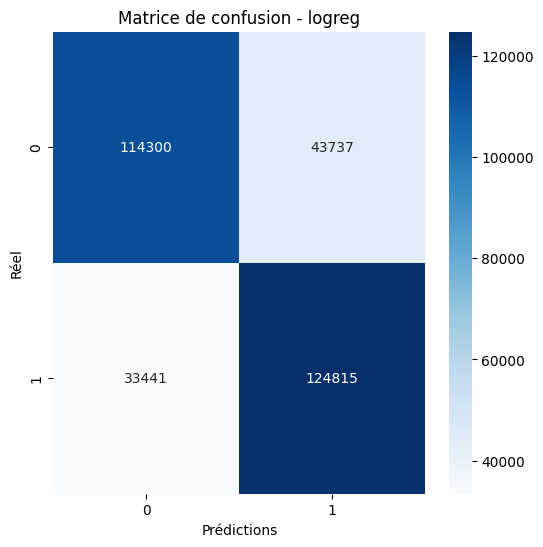


📊 Résultats pour : rf
              precision    recall  f1-score   support

           0       0.73      0.75      0.74    158037
           1       0.74      0.72      0.73    158256

    accuracy                           0.73    316293
   macro avg       0.73      0.73      0.73    316293
weighted avg       0.73      0.73      0.73    316293



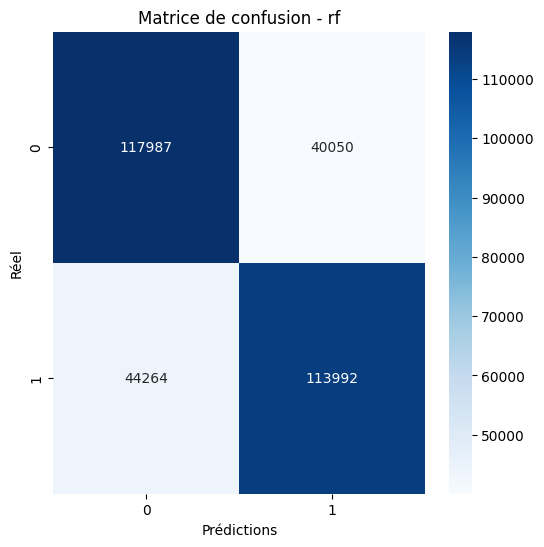

9885/9885 ━━━━━━━━━━━━━━━━━━━━ 9s 845us/step

📊 Résultats pour : lstm
              precision    recall  f1-score   support

           0       0.78      0.77      0.77    158037
           1       0.77      0.78      0.78    158256

    accuracy                           0.78    316293
   macro avg       0.78      0.78      0.78    316293
weighted avg       0.78      0.78      0.78    316293



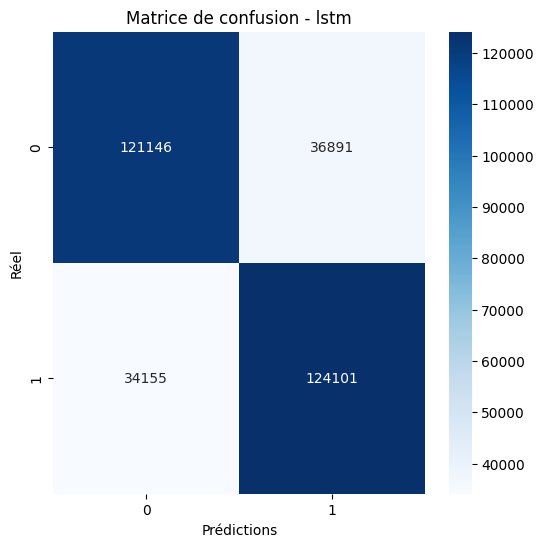


📊 Résultats pour : lgbm
              precision    recall  f1-score   support

           0       0.72      0.71      0.71      1505
           1       0.71      0.72      0.72      1495

    accuracy                           0.72      3000
   macro avg       0.72      0.72      0.72      3000
weighted avg       0.72      0.72      0.72      3000



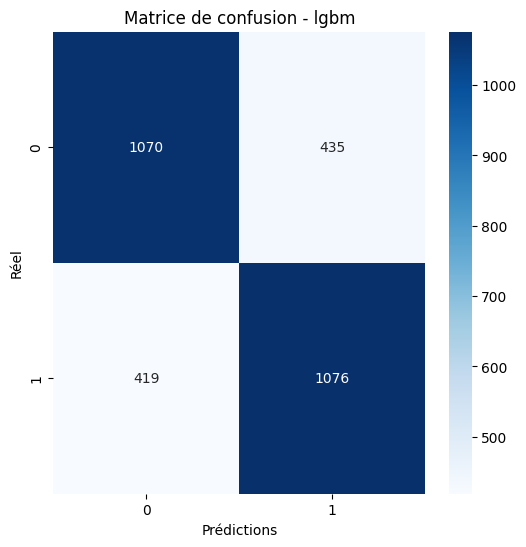


📊 Comparaison finale des modèles :


,Modèle,Accuracy,F1-score
0,logreg,0.7560,0.7638
1,rf,0.7334,0.7300
2,lstm,0.7754,0.7775
3,lgbm,0.7153,0.7159
4,DistilBERT fine-tuné,0.8423,0.8427


🏃 View run whimsical-lark-463 at: http://127.0.0.1:5000/#/experiments/2/runs/14fae9e28175464a877710f42b5eb5d1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.


In [ ]:
df_results = ev.get_all_model_scores(models_dict, datasets_dict)

# 9 - Tracking MLFlow

In [ ]:
y_pred = log_reg_model.predict(X_tfidf_test)
with mlflow.start_run(run_name="Logistic Regression final metrics"):
    mlflow.log_param("model", "Logistic Regression")
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred))
    mlflow.log_metric("f1_score", f1_score(y_test, y_pred))

🏃 View run Logistic Regression final metrics at: http://127.0.0.1:5000/#/experiments/2/runs/a5b1b98b6d914317bf0d69495abfd57f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [ ]:
if mlflow.active_run() is not None:
    mlflow.end_run()

In [ ]:
with mlflow.start_run():
    # entraînement modèle, log params & metrics
    mlflow.log_param("model", "Logistic Regression")
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred))

🏃 View run big-fowl-347 at: http://127.0.0.1:5000/#/experiments/2/runs/b15618770e944f1b9e65a6e923af788d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


# A désactiver en production

In [ ]:
utils.launch_mlflow_ui()

🚀 MLFlow UI lancé sur http://127.0.0.1:5000


In [ ]:
# mlflow.end_run()  # Pour stopper tout run en cours
